<a href="https://colab.research.google.com/github/Oreolorun/Image-Recognition/blob/main/CarTypeImageRegcognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1.0 Overview**
The purpose of this project is to create a classification model capable of correctly classifying images of vehicles as sedans, coupes, SUVs or trucks.


In [ ]:
#  importing libraries 
import os
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
!pip install shap
import shap
import shutil

In [3]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


## **2.0 Data**
Image data for this project was scraped from webpages, details of scrapper can be found in the WebScrapper.ipynb file. Approximately 81,000 images were scraped, evenly distributed across all 4 car classes so as to avoid class imbalance.

In [ ]:
def count_classes(parent_path):
  """
  This function counts the number of images in each directory
  """
  #  instantiating counters for each class
  sedan = 0
  coupe = 0
  suv = 0
  truck = 0
  #  creating a dictionary of folders
  folders = {'sedans':sedan, 'coupes':coupe, 'suvs':suv, 'trucks':truck}
  
  #  looping through folders
  for folder in tqdm(folders):
    for f in os.listdir(os.path.join(parent_path, folder)):
      folders[folder]+=1

  #  printing count
  print(f'\n\n{folders}\nTotal: {sum(list(folders.values()))}')
  
  #  ploting bar chart
  return sns.barplot(x = list(folders.keys()), y = list(folders.values())) 

100%|██████████| 4/4 [00:01<00:00,  3.03it/s]



{'sedans': 20290, 'coupes': 20307, 'suvs': 20425, 'trucks': 20317}
Total: 81339


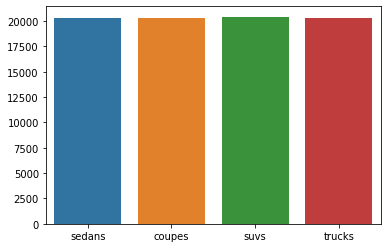

In [ ]:
#  counting
count_classes('gdrive/My Drive/Datasets/Car_Images')

### **2.1 Loading Data**
Below images are loaded and labeled in numpy array format then appended to a list. Said list is then shuffled and saved in a numpy array file format (.npy) to prevent rebuilding the dataset each time the runtime is connected.


In [13]:
#  loading and labelling data

class LoadVehicleData():
  """
  This class loads in data from each directory in numpy array format then saves
  loaded dataset
  """
  def __init__(self):
    self.sedans = 'gdrive/My Drive/Datasets/Car_Images/test_images/test_sedans'
    self.coupes = 'gdrive/My Drive/Datasets/Car_Images/test_images/test_coupes'
    self.suvs = 'gdrive/My Drive/Datasets/Car_Images/test_images/test_suvs'
    self.trucks = 'gdrive/My Drive/Datasets/Car_Images/test_images/test_trucks'
    self.labels = {self.sedans:0, self.coupes:1, self.suvs:2, self.trucks:3}
    self.img_size = 75
    self.training_data = []
    self.sedan_count = 0
    self.coupe_count = 0
    self.suv_count = 0
    self.truck_count = 0

  def create_dataset(self, rebuild=True):
    """
    This method builds a dataset 
    """
    if rebuild:
      for key in self.labels:
        print(key)
        #  looping through all files in the directory
        for img_file in tqdm(os.listdir(key)):
          try:
            #  deriving image path
            path = os.path.join(key, img_file)
            #  reading image
            image = cv2.imread(path)
            image = cv2.resize(image, (self.img_size, self.img_size))
            image = np.array(image)
            #  appending image and class label to list
            self.training_data.append([image, int(self.labels[key])])
            #  incrementing counter
            if key == self.sedans:
              self.sedan_count+=1
            elif key == self.coupes:
              self.coupe_count+=1
            elif key == self.suvs:
              self.suv_count+=1
            elif key == self.trucks:
              self.truck_count+=1
          except Exception as e:
            pass
      #  shuffling array of images
      np.random.shuffle(self.training_data)
      #  saving array
      np.save('gdrive/My Drive/Neural Networks/loaded_npy_files/Car75_testUS.npy', 
              self.training_data)
      #  printing to screen
      print(f'\nsedan images: {self.sedan_count}')
      print(f'coupe images: {self.coupe_count}')
      print(f'suv images: {self.suv_count}')
      print(f'truck images: {self.truck_count}')
      print(f'total: {self.sedan_count + self.coupe_count + self.suv_count + self.truck_count}')
      print('All done!')
    else:
      print('Rebuild argument set to false, data will be loaded into the dataset'+ 
            ' object from specified path.\nSet rebuild to true to rebuild dataset.')
      pass

In [29]:
#  creating an instance of the class LoadVehicleData
data = LoadVehicleData()

#  creating dataset
data.create_dataset(rebuild=False)

#  loading dataset into object
dataset = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/CarType100x100.npy', allow_pickle=True)
print('\nDone!')

Rebuild argument set to false, data will be loaded into the dataset object from specified path.
Set rebuild to true to rebuild dataset.

Done!


In [ ]:
#  checking dataset
len(dataset)

81332

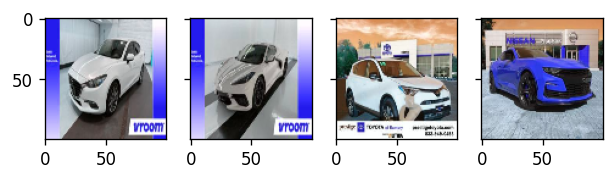

In [ ]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=120, sharey=True)
axes[0].imshow(dataset[2457][0])
axes[1].imshow(dataset[1][0])
axes[2].imshow(dataset[23967][0])
axes[3].imshow(dataset[19929][0])

### **2.2 Training, Validation and Test Splits**
Ten percent (8,133) of the dataset is reserved as test set while another 20% (14,639) of the remaining data is set aside as validation set leaving 70% (58,560) of the data for training purposes.

In [30]:
#  defining splitting function
def train_val_split(dataset_to_split, val_pct):
  #  deriving dataset length
  number_of_instances = len(dataset_to_split)
  #  deriving length of validattion set
  val_idx = int(number_of_instances*val_pct)
  #  deriving random permutations of the whole dataset
  idx = list(np.random.permutation(number_of_instances))
  return idx[:val_idx], idx[val_idx:]

#  creating testing, validation and training indices
#test_indices, dataset_indices = train_val_split(dataset, 0.1)
#val_indices, train_indices = train_val_split(dataset_indices, 0.2)

#  saving indices for reproducbility
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', train_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', val_indices)
#np.save(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', test_indices)

#  loading saved indices
train_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/train_indices_{str(len(dataset))}.npy', allow_pickle=True))
val_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/val_indices_{str(len(dataset))}.npy', allow_pickle=True))
test_indices = list(np.load(f'gdrive/My Drive/Neural Networks/loaded_npy_files/test_indices_{str(len(dataset))}.npy', allow_pickle=True))

#  splitting into training, validation and test sets
training_set = dataset[train_indices]
validation_set = dataset[val_indices]
test_set = dataset[test_indices]

### **2.3 Working with Custom Dataset**
In order to use my custom dataset, I extended the pytorch Dataset class.

In [31]:
#  extending Dataset class
class VehicleDataset(Dataset):
  def __init__(self, loaded_dataset, transforms=None):
    self.loaded_dataset = loaded_dataset
    self.transforms = transforms

  def __len__(self):
    return len(self.loaded_dataset)
  
  def __getitem__(self, idx):
    #  extracting image from index and scaling
    image = self.loaded_dataset[idx][0]/255
    #  extracting label from index
    label = torch.tensor(int(self.loaded_dataset[idx][1]))
    #  applying transforms if transforms are supplied
    if self.transforms:
      image = self.transforms(image)
    return (image, label)

In [32]:
#  creating instances of the dataset class
train_ds = VehicleDataset(training_set, transforms=transforms.ToTensor())
val_ds = VehicleDataset(validation_set, transforms=transforms.ToTensor())
test_ds = VehicleDataset(test_set, transforms=transforms.ToTensor())

#  creating dataloaders
batch_size = 100
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True) 
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

## **3.0 Network Architecture**
A convolutional neural network is used for this project. This CNN is losely based on the VGG group of architectures which use multiple convolution blocks before maxpooling. This particular CNN is 9 layers deep so as to better zero in on the nuances of each car class since sedans and coupes tend to have similar features.

Two distinct networks are built, one which works on 75x75px images and another which works on 100x100px images. I have choosen to do this so as to feed two different instances of the same image to the same neural network, with one instance (100x100px) showing more features to the convolutional neural network. The hypothesis here is that with more features, perharps better performance will be obtained.

Baseline models will be generated for each network. These baselines try to prevent overfitting only by monitoring training and validation metrics. Afterwards, models which handle overfitting with both metrics monitoring and batch normalization will be built.

In [19]:
#  building neural network for 100px (baseline)
class CarRecognition_100(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.conv1(x))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool4(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool7(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [20]:
#  building neural network for 75px images (baseline)
class CarRecognition_75(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(2048, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)

  def forward(self, x):
    x = x.view(-1, 3, 75, 75).float()
    x = F.relu(self.conv1(x))
    x = self.pool2(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool4(F.relu(self.conv4(x)))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.pool7(F.relu(self.conv7(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [21]:
#  building neural network (100px with batchnorm)
class CarRecognition_bn100(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(8192, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)
    self.batchnorm_conv1 = nn.BatchNorm2d(32)
    self.batchnorm_conv2 = nn.BatchNorm2d(32)
    self.batchnorm_conv3 = nn.BatchNorm2d(64)
    self.batchnorm_conv4 = nn.BatchNorm2d(64)
    self.batchnorm_conv5 = nn.BatchNorm2d(128)
    self.batchnorm_conv6 = nn.BatchNorm2d(128)
    self.batchnorm_conv7 = nn.BatchNorm2d(128)
    self.batchnorm_fc1 = nn.BatchNorm1d(514)
    self.batchnorm_fc2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = x.view(-1, 3, 100, 100).float()
    x = F.relu(self.batchnorm_conv1(self.conv1(x)))
    x = self.pool2(F.relu(self.batchnorm_conv2(self.conv2(x))))
    x = F.relu(self.batchnorm_conv3(self.conv3(x)))
    x = self.pool4(F.relu(self.batchnorm_conv4(self.conv4(x))))
    x = F.relu(self.batchnorm_conv5(self.conv5(x)))
    x = F.relu(self.batchnorm_conv6(self.conv6(x)))
    x = self.pool7(F.relu(self.batchnorm_conv7(self.conv7(x))))
    x = torch.flatten(x,1)
    x = F.relu(self.batchnorm_fc1(self.fc1(x)))
    x = F.relu(self.batchnorm_fc2(self.fc2(x)))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [22]:
#  building neural network (75px with batchnorm)
class CarRecognition_bn75(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128 ,3)
    self.conv7 = nn.Conv2d(128, 128, 3)
    self.fc1 = nn.Linear(2048, 514)
    self.fc2 = nn.Linear(514, 128)
    self.fc3 = nn.Linear(128, 4)
    self.pool2 = nn.MaxPool2d(2,2)
    self.pool4 = nn.MaxPool2d(2,2)
    self.pool7 = nn.MaxPool2d(2,2)
    self.batchnorm_conv1 = nn.BatchNorm2d(32)
    self.batchnorm_conv2 = nn.BatchNorm2d(32)
    self.batchnorm_conv3 = nn.BatchNorm2d(64)
    self.batchnorm_conv4 = nn.BatchNorm2d(64)
    self.batchnorm_conv5 = nn.BatchNorm2d(128)
    self.batchnorm_conv6 = nn.BatchNorm2d(128)
    self.batchnorm_conv7 = nn.BatchNorm2d(128)
    self.batchnorm_fc1 = nn.BatchNorm1d(514)
    self.batchnorm_fc2 = nn.BatchNorm1d(128)

  def forward(self, x):
    x = x.view(-1, 3, 75, 75).float()
    x = F.relu(self.batchnorm_conv1(self.conv1(x)))
    x = self.pool2(F.relu(self.batchnorm_conv2(self.conv2(x))))
    x = F.relu(self.batchnorm_conv3(self.conv3(x)))
    x = self.pool4(F.relu(self.batchnorm_conv4(self.conv4(x))))
    x = F.relu(self.batchnorm_conv5(self.conv5(x)))
    x = F.relu(self.batchnorm_conv6(self.conv6(x)))
    x = self.pool7(F.relu(self.batchnorm_conv7(self.conv7(x))))
    x = torch.flatten(x,1)
    x = F.relu(self.batchnorm_fc1(self.fc1(x)))
    x = F.relu(self.batchnorm_fc2(self.fc2(x)))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

## **4.0 Model Training and Validation**
### **4.1 Accuracy Funtion**

In [26]:
def accuracy(network, train_loader, verbose=False):
  """
  this function calculates accuracy
  """
  #  instantiating model state
  network.eval()
  #  creating counter for correctly classified instances
  correctly_classified = 0
  #  creating counter for all instances
  all_instances = 0

  #  looping through every batch
  for images, labels in tqdm_notebook(train_loader):
    images, labels = images.to(device), labels.to(device)
    #  classifying
    outputs = network(images)
    #  deriving the index of model prediction
    predicted_labels = torch.argmax(outputs, dim=1)
    #  comparing and counting the number of correct predictions
    correct_labels = sum(predicted_labels==labels)
    #  counting correct predictions
    correctly_classified+=correct_labels.item()
    #  counting all instances
    all_instances+=len(labels)

  if verbose:
    return print(f'[{correctly_classified}/{all_instances}]\nmodel predicts all'+ 
                 f' instances to {round((correctly_classified/all_instances)*100, 2)}% accuracy')
  else:
    return correctly_classified/all_instances

### **4.2 Training Function**

In [ ]:
def train_model(network, epochs, loss_function, opt, train_loader, val_loader):
  """
  this function trains a neural network and calculates metrics on both the
  training set and the validation set 
  """
  #  creating a list to hold metrics
  metric_log = []

  for epoch in range(epochs):
    #  instantiating model state
    network.train()

    #  training
    print(f'\nTraining Epoch {epoch+1}/{epochs}')
    total_loss = 0
    total_instances = 0
    for images, labels in tqdm_notebook(train_loader):
      #  sending to device
      images, labels = images.to(device), labels.to(device)
      #  resetting gradients
      opt.zero_grad()
      #  classifying
      outputs = network(images)
      #  computing loss
      loss = loss_function(outputs, labels)
      with torch.no_grad():
        #  summing loss
        total_loss+=loss.sum().item()
        #  summing instances
        total_instances+=len(labels)
      #  computing gradients
      loss.backward()
      #  optimizing
      opt.step()
    #  deriving training accuracy
    with torch.no_grad():
      print('Deriving training accuracy...')
      train_accuracy = accuracy(network, train_loader)

    #  deriving validation loss and accuracy
    with torch.no_grad():
      print('Deriving validation loss...')
      total_val_loss = 0
      total_val_instances = 0
      for val_images, val_labels in tqdm_notebook(val_loader):
        #  sending to device
        val_images, val_labels = val_images.to(device), val_labels.to(device)
        #  classifying
        val_outputs = network(val_images)
        #  computing loss
        val_loss = loss_function(val_outputs, val_labels)
        #  summing val_loss
        total_val_loss+=val_loss.sum().item()
        #  summing total_val_instances
        total_val_instances+=len(val_labels)
      print('Deriving validation accuracy...')
      #  computing accuracy
      val_accuracy = accuracy(network, val_loader)
    #  appending metrics to list
    metric_log.append([epoch+1, total_loss/total_instances, 
                       train_accuracy, total_val_loss/total_val_instances, 
                       val_accuracy])
    
    #  displaying results
    print(f'Epoch: {epoch+1}/{epochs}'+
          f' Training_loss: {round(total_loss/total_instances, 5)}'+
          f' Training_accuracy: {round(train_accuracy, 5)}'+
          f' Validation_loss: {round(total_val_loss/total_val_instances, 5)}'+ 
          f' Validation_accuracy: {round(val_accuracy, 5)}')
    #if round(val_accuracy, 5) > 0.95000:
      #break
  #  saving metrics
  #np.save(f'gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-3.npy', metric_log)
  print('\nDone!')

### **4.3 Training and Validation Loop**

In [ ]:
#  instantiating model
model = CarRecognition_bn100()
model.to(device)

#  instantiating loss function
loss_fn = nn.NLLLoss()

#  instantiating optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 30

#  training model
train_model(network=model, epochs=epochs, loss_function=loss_fn, 
            opt=optimizer, train_loader=train_dl, val_loader=val_dl)

In [ ]:
#  saving model state
#torch.save(model.state_dict(), f'gdrive/My Drive/Neural Networks/Model_States/CarType100_model_state_1e-3_10ep.pt')

### **4.4 Model Metrics**

In [ ]:
#  loading metrics
#  each object is named with its learning rate as the last two characters or bl for the baseline
metrics_75e1 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_bn_30epochs.npy', allow_pickle=True)
metrics_75e2 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_bn_30epochs_1e-2.npy', allow_pickle=True)
metrics_75e3 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_bn_30epochs_1e-3.npy', allow_pickle=True)
metrics_75bl = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_30epochs.npy', allow_pickle=True)

metrics_100e1 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-1.npy', allow_pickle=True)
metrics_100e2 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-2.npy', allow_pickle=True)
metrics_100e3 = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-3.npy', allow_pickle=True)
metrics_100bl = np.load('gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_30epochs.npy', allow_pickle=True)

In [ ]:
#  plot function
def plot_line(metrics_1, metrics_2, metrics_3=[], labels=[]):
  """
  This function plots model metrics
  """
  #  axes and labels
  if len(metrics_3) == 0:
    figure, axes = plt.subplots(2,2, dpi=280, sharex=True)
    axes[0,0].set_title('training_accuracy vs epoch')
    axes[0,1].set_title('validation_accuracy vs epoch')
    axes[1,0].set_title('training_loss vs epoch')
    axes[1,1].set_title('validation_loss vs epoch')

    #  plotting
    sns.lineplot(x=metrics_1[:,0], y=metrics_1[:,2], label=labels[0], ax=axes[0,0])
    sns.lineplot(x=metrics_2[:,0], y=metrics_2[:,2], label=labels[1], ax=axes[0,0])

    sns.lineplot(x=metrics_1[:,0], y=metrics_1[:,4], label=labels[0], ax=axes[0,1])
    sns.lineplot(x=metrics_2[:,0], y=metrics_2[:,4], label=labels[1], ax=axes[0,1])

    sns.lineplot(x=metrics_1[:,0], y=metrics_1[:,1], label=labels[0], ax=axes[1,0])
    sns.lineplot(x=metrics_2[:,0], y=metrics_2[:,1], label=labels[1], ax=axes[1,0])

    sns.lineplot(x=metrics_1[:,0], y=metrics_1[:,3], label=labels[0], ax=axes[1,1])
    sns.lineplot(x=metrics_2[:,0], y=metrics_2[:,3], label=labels[1], ax=axes[1,1])

  else:
    #  axes and labels
    figure, axes = plt.subplots(2,2, dpi=280, sharex=True)
    axes[0,0].set_title('training_accuracy vs epoch')
    axes[0,1].set_title('validation_accuracy vs epoch')
    axes[1,0].set_title('training_loss vs epoch')
    axes[1,1].set_title('validation_loss vs epoch')

    #  plotting
    sns.lineplot(x=metrics_1[:,0], y=metrics_1[:,2], label=labels[0], ax=axes[0,0])
    sns.lineplot(x=metrics_2[:,0], y=metrics_2[:,2], label=labels[1], ax=axes[0,0])
    sns.lineplot(x=metrics_3[:,0], y=metrics_3[:,2], label=labels[2], ax=axes[0,0])

    sns.lineplot(x=metrics_1[:,0], y=metrics_1[:,4], label=labels[0], ax=axes[0,1])
    sns.lineplot(x=metrics_2[:,0], y=metrics_2[:,4], label=labels[1], ax=axes[0,1])
    sns.lineplot(x=metrics_3[:,0], y=metrics_3[:,4], label=labels[2], ax=axes[0,1])

    sns.lineplot(x=metrics_1[:,0], y=metrics_1[:,1], label=labels[0], ax=axes[1,0])
    sns.lineplot(x=metrics_2[:,0], y=metrics_2[:,1], label=labels[1], ax=axes[1,0])
    sns.lineplot(x=metrics_3[:,0], y=metrics_3[:,1], label=labels[2], ax=axes[1,0])

    sns.lineplot(x=metrics_1[:,0], y=metrics_1[:,3], label=labels[0], ax=axes[1,1])
    sns.lineplot(x=metrics_2[:,0], y=metrics_2[:,3], label=labels[1], ax=axes[1,1])
    sns.lineplot(x=metrics_3[:,0], y=metrics_3[:,3], label=labels[2], ax=axes[1,1])

#### 4.4.1 **Batch Normalized vs Baseline Model**
Since the baseline model is trained using a learning rate of 1e-3, a batch normalized model with the same learning rate is used for comparision. This is done for both the 75px and 100px networks.

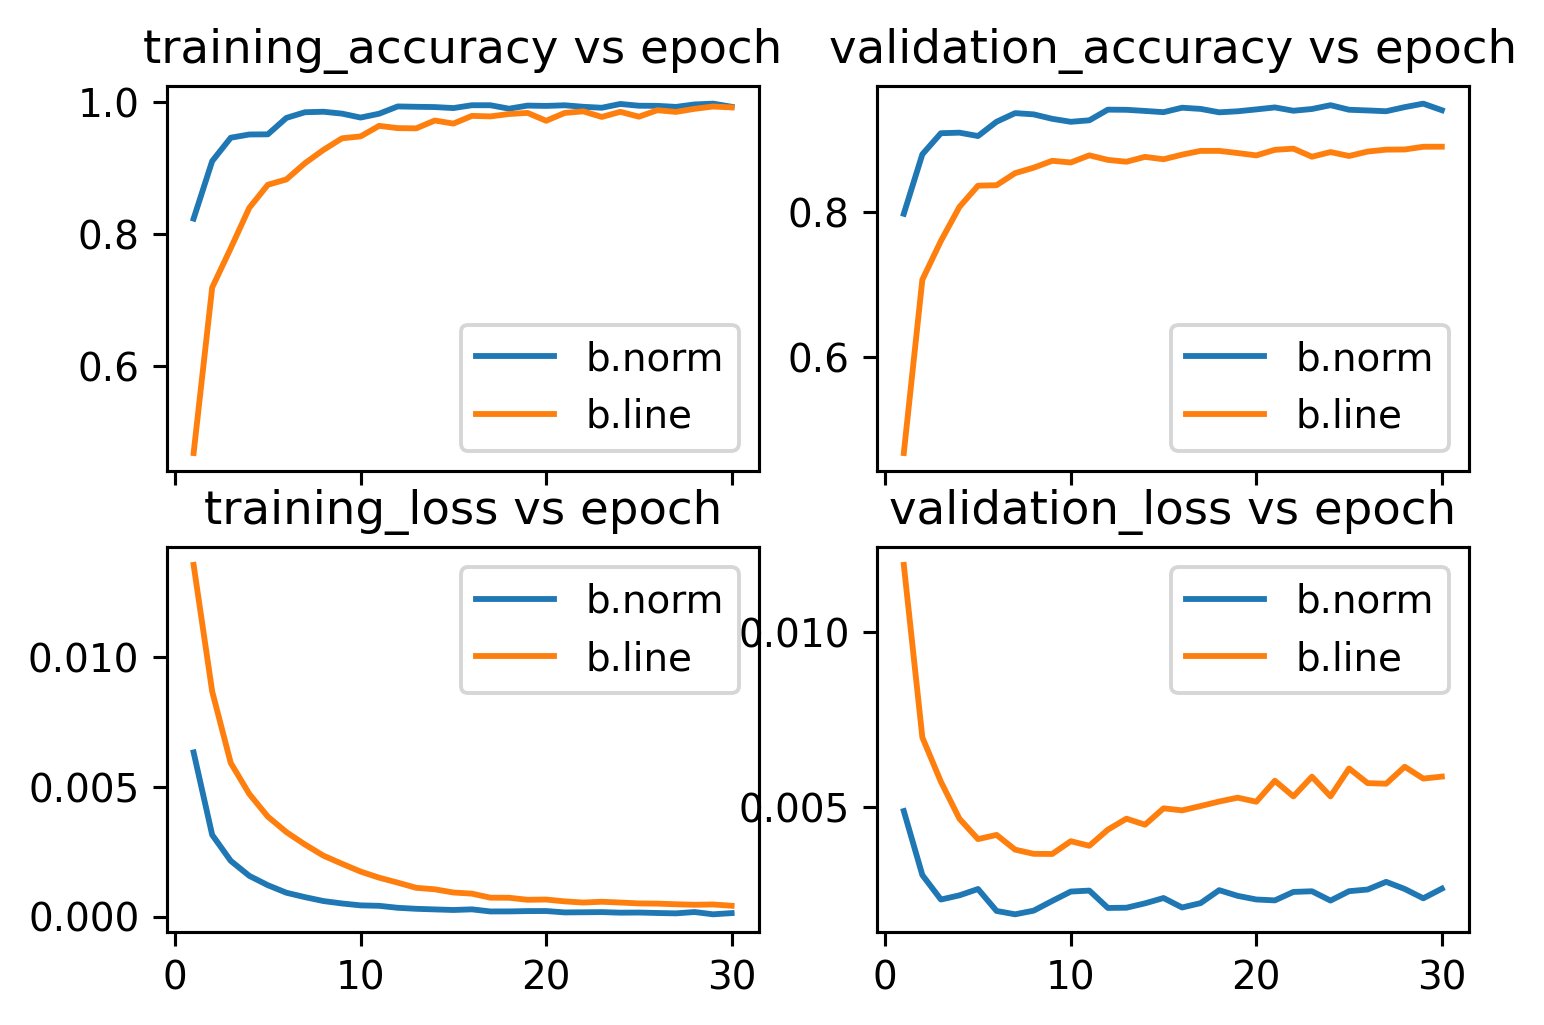

In [ ]:
#  75px 
plot_line(metrics_75e3, metrics_75bl,
          labels=['b.norm', 'b.line'])

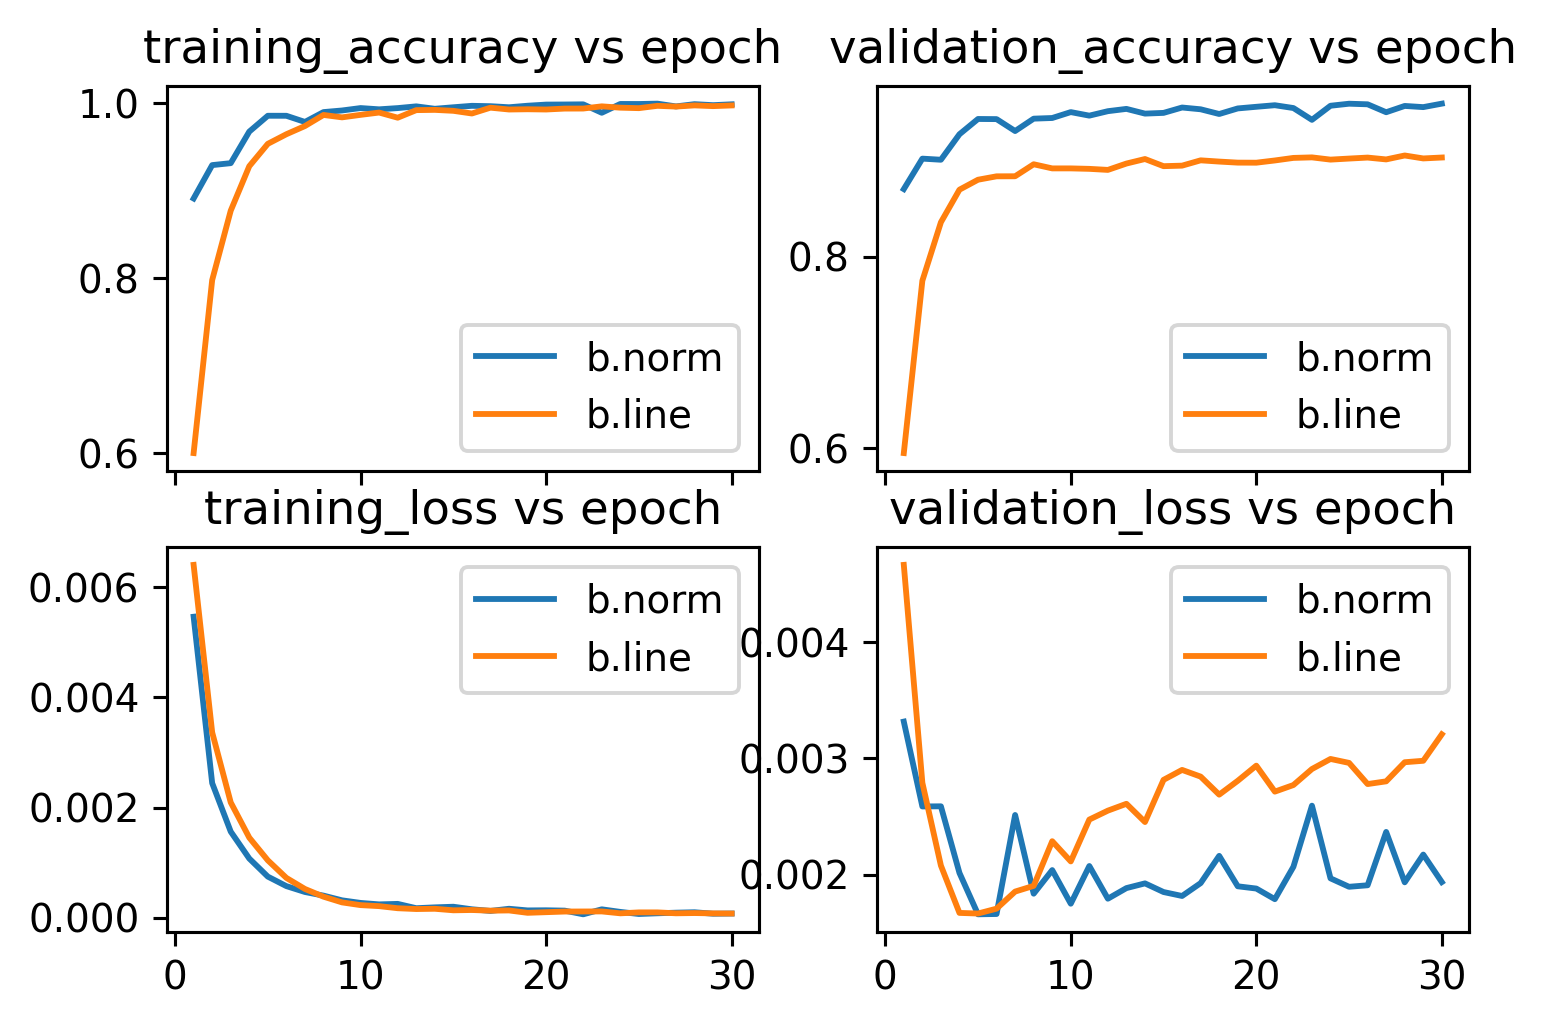

In [ ]:
#  100px
plot_line(metrics_100e3, metrics_100bl,
          labels=['b.norm', 'b.line'])

For both models, the batch normalized versions obtained a higher accuracy and a lower and more stable loss comapred to the baselines. Therefore, the batch normalized models will be selected as final models.

#### 4.4.2 **Optimising the Batch Normalized Models**
Optimisation of the batch normalized models is done by varying the learning rate.

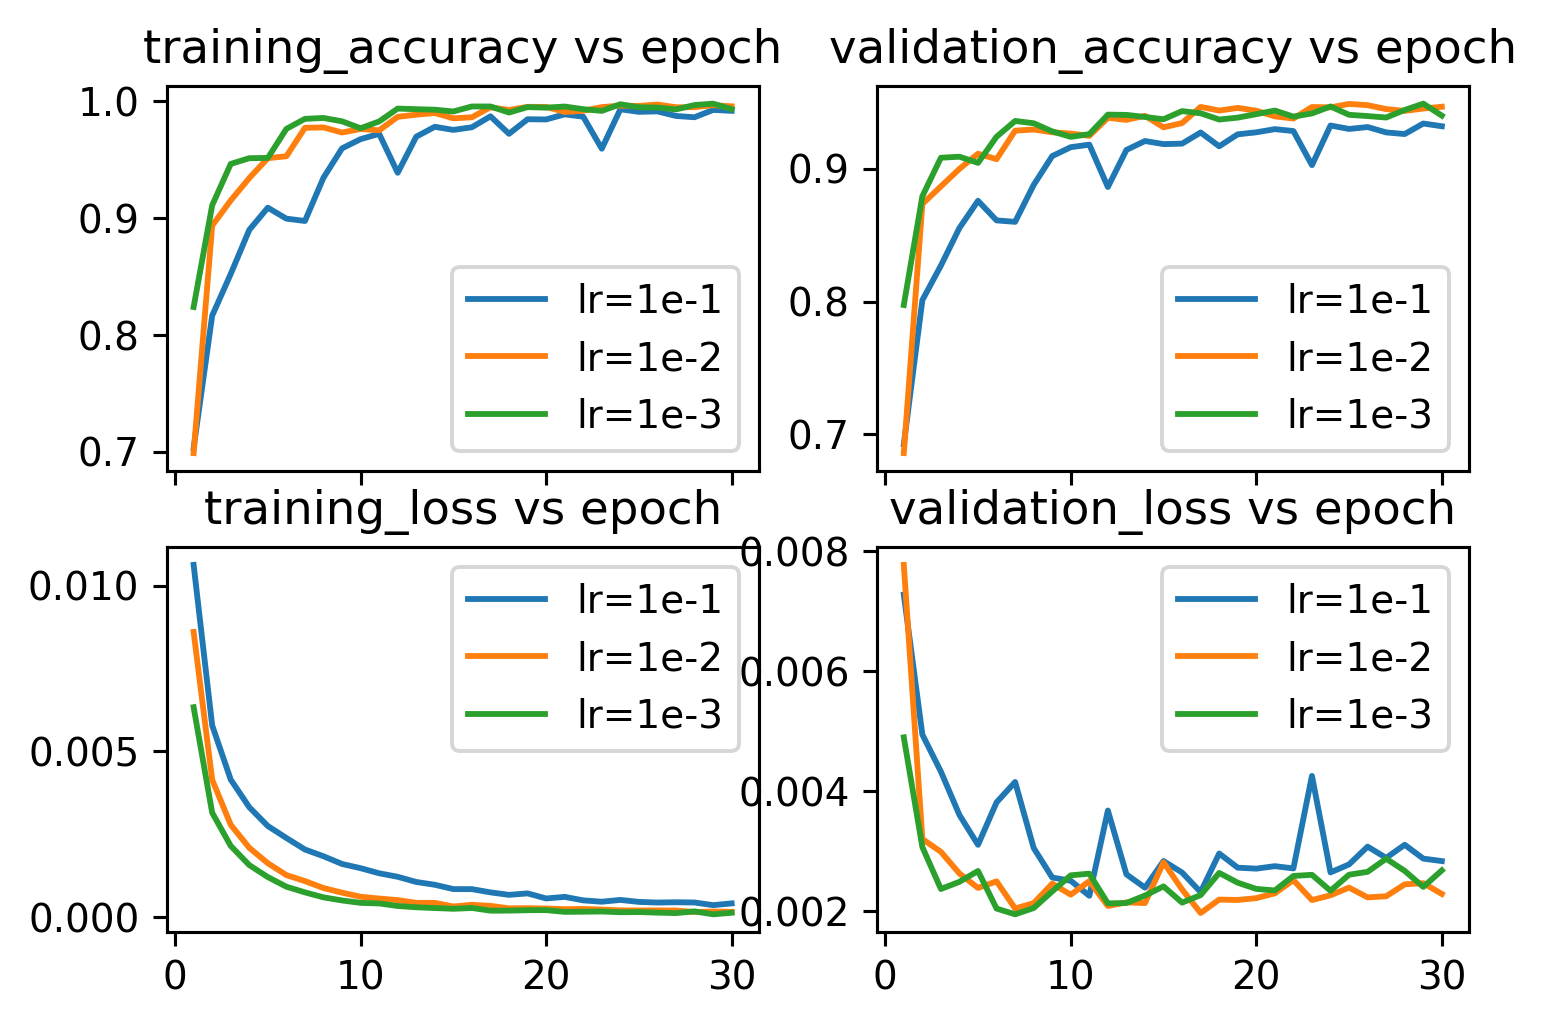

In [ ]:
#  comparing learning rates for the 75px model
plot_line(metrics_75e1, metrics_75e2,
          metrics_75e3, labels=['lr=1e-1', 'lr=1e-2', 'lr=1e-3'])

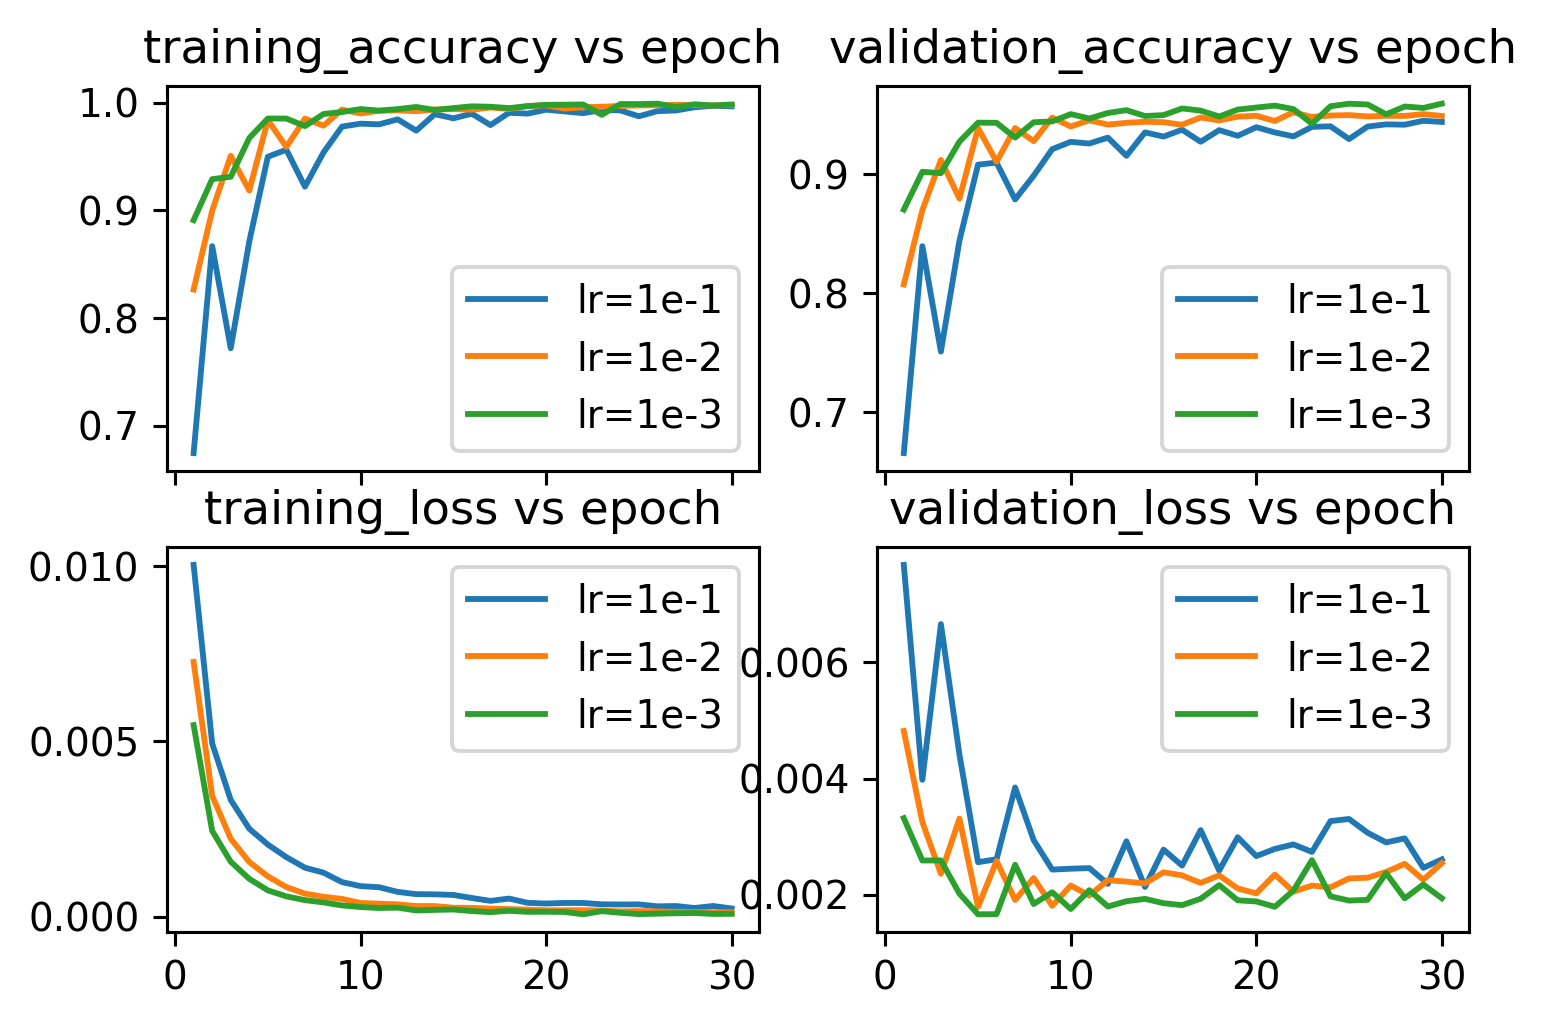

In [ ]:
#  comparing learning rates for the 100px model
plot_line(metrics_100e1, metrics_100e2,
          metrics_100e3, labels=['lr=1e-1', 'lr=1e-2', 'lr=1e-3'])

From the plots it us seen that a learning rate of 1e-2 is satisfactory for both models as it either converges faster or produces a more stable loss

#### **4.4.3 Metrics in DataFrame** 

In [4]:
#  defining function to convert metric array to dataframe
def metric_to_df(path):
  """
  this function takes a specified path as argument, 
  loads in the .npy file at said path and converts 
  it into a pandas dataframe
  """
  metric_array = np.load(path, allow_pickle=True)
  df = pd.DataFrame({'epoch': metric_array[:,0], 
                     'training_loss': metric_array[:,1],
                     'training_accuracy': metric_array[:,2],
                     'validation_loss': metric_array[:,3],
                     'validation_accuracy': metric_array[:,4]})
  return df

In [11]:
#  loading metrics
metrics_path_1 = 'gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType75x75_bn_30epochs_1e-2.npy'
metrics_path_2 = 'gdrive/My Drive/Neural Networks/Model_Metric_Logs/CarType100x100_bn_30epochs_1e-2.npy'

#  creating a dataframe of metrics
metrics_75 = metric_to_df(metrics_path_1)
metrics_100 = metric_to_df(metrics_path_2)

#  merging dataframes
combined_metrics = metrics_75.merge(metrics_100, suffixes=['_75', '_100'], 
                                    left_index=True, right_index=True)

In [12]:
combined_metrics.head()

epoch_75  training_loss_75  ...  validation_loss_100  validation_accuracy_100
0       1.0          0.008602  ...             0.004820                 0.807432
1       2.0          0.004145  ...             0.003249                 0.869936
2       3.0          0.002787  ...             0.002359                 0.912084
3       4.0          0.002092  ...             0.003309                 0.879568
4       5.0          0.001628  ...             0.001788                 0.938930

[5 rows x 10 columns]

#### **4.4.4 Test Set Classification**
The vatch normalized models are trained for their optimal number of epochs (17 for the 75px model and 9 for the 100px model). The baseline models are also trained to their optimal epochs for benchmark and comparision sake.

For convinience, the baseline models will be called model_75 and model_100 for the 75px and 100px models respectively. The batch normalized models will be named model_75x and model_100x.

In [23]:
#  loading model states
model_100 = CarRecognition_100()
model_100.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType100x100_model_state_completed.pt', map_location=device))

model_75 = CarRecognition_75()
model_75.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType75x75_model_state_completed.pt', map_location=device))

model_100x = CarRecognition_bn100()
model_100x.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType100_model_state_1e-2_9ep.pt', map_location=device))

model_75x = CarRecognition_bn75()
model_75x.load_state_dict(torch.load('gdrive/My Drive/Neural Networks/Model_States/CarType75_model_state_1e-2_17ep.pt', map_location=device))

<All keys matched successfully>

In [27]:
#  test accuracy model_75
accuracy(model_75, test_dl, verbose=True)

  0%|          | 0/82 [00:00<?, ?it/s]

[7627/8133]
model predicts all instances to 93.78% accuracy


In [28]:
#  test accuracy model_75x
accuracy(model_75x, test_dl, verbose=True)

  0%|          | 0/82 [00:00<?, ?it/s]

[7950/8133]
model predicts all instances to 97.75% accuracy


In [33]:
#  test accuracy model_100
accuracy(model_100, test_dl, verbose=True)

  0%|          | 0/82 [00:00<?, ?it/s]

[7803/8133]
model predicts all instances to 95.94% accuracy


In [34]:
#  test accuracy model_100x
accuracy(model_100x, test_dl, verbose=True)

  0%|          | 0/82 [00:00<?, ?it/s]

[7965/8133]
model predicts all instances to 97.93% accuracy


From the accuracy scores it is seen that the batch normalized models out performed the baselines with the batch normalized 100px obtaining the highest accuracy score of 97.93%.

However, this is not a suitable comparision of all models. This is down to the way the dataset was loaded and built, the dataset for 75px images is arranged differently from that of the 100px images since there is a random shuffle in the dataset building method.

In order to properly compare all models, more data will be scraped and used for testing in later sections.

### **4.5 Model Explainability and Visual Tests**
Tests are performed on individual images so as to compare the performance of each model. Afterwards, SHAP plots are produced so as to better understand why each model as predicted the way it did. The logic behind this is to assess the individual strengths and weaknesses of each model.

SHAP plots help to explain why a model as made a specific classification be returning an image representing all 4 classes with significant pixels color coded. Blue pixels represent features which reduce the likelihood of an image belonging to that particular class while red pixels imply the opposite. A model predicts a given class if there are more red pixels or less blue pixels compared to other classes.

In [35]:
#  defining visual test function
def visual_test(path, model_1, model_2,
                model_3=None, model_4=None, num_models=2):
  """
  This function classifies an image using a number of models and returns a plot
  of said image. It also ensembles all models to provide an insight on how
  effective ensembling will be for that particular instance.
  """
  if num_models == 2:
    #  setting model mode
    model_1.eval()
    model_2.eval()

    with torch.no_grad():
      #  reading image
      vt_img = cv2.imread(path) #  vt_img stands for visual test image
      vt_img = cv2.resize(vt_img, (75,75))
      #  converting to tensor
      vt_img_tensor = transforms.ToTensor()(vt_img)
      #  predicting
      out = model_1(vt_img_tensor)
      #  class dictionary
      output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
      #  extracting probabilities
      probability = F.softmax(F.softmax(out, dim=1), dim=1)*100
      #  output
      print('model 75x75px')
      print(f'sedan: {probability[0][0].round()}%, coupe: {probability[0][1].round()}%,' 
            +f' suv: {probability[0][2].round()}%, truck: {probability[0][3].round()}%')
      print(f'prediction: {output_dict[torch.argmax(out).item()]}')
      print('_'*55)

      #  predicting for model 2
      vt_img = cv2.imread(path)
      vt_img = cv2.resize(vt_img, (100,100))
      plt.imshow(vt_img)
      vt_img_tensor = transforms.ToTensor()(vt_img)
      out = model_2(vt_img_tensor)
      output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
      probability_2 = F.softmax(F.softmax(out, dim=1), dim=1)*100
      print('model 100x100px')
      print(f'sedan: {probability_2[0][0].round()}%, coupe: {probability_2[0][1].round()}%,' 
            +f' suv: {probability_2[0][2].round()}%, truck: {probability_2[0][3].round()}%')
      print(f'prediction: {output_dict[torch.argmax(out).item()]}')
      print('_'*55)

      #  average ensemble
      print('average class prediction')
      avg = np.array(([probability.numpy()], [probability_2.numpy()]))
      avg = avg.reshape(2,4)
      avg = avg.mean(axis=0)
      print(f'sedan: {avg[0].round()}%, coupe: {avg[1].round()}%,' 
            +f' suv: {avg[2].round()}%, truck: {avg[3].round()}%')
      print(f'prediction: {output_dict[np.argmax(avg)]}')
      print('_'*55)

      #  highest confidence ensemble
      print('highest confidence')
      confidence =  torch.concat((probability, probability_2), dim=1)
      highest_conf = torch.argmax(confidence)
      out_hc_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck',
                    4:'sedan', 5:'coupe', 6:'suv', 7:'truck'}
      print(f'sedan: {confidence[0][0].round()}%, coupe: {confidence[0][1].round()}%,' 
            +f' suv: {confidence[0][2].round()}%, truck: {confidence[0][3].round()}%'
            +f'\nsedan: {confidence[0][4].round()}%, coupe: {confidence[0][5].round()}%,'
            +f' suv: {confidence[0][6].round()}%, truck: {confidence[0][7].round()}%')
      print(f'prediction: {out_hc_dict[highest_conf.item()]}') 

  #  the above logic is repeated to allow for 4 models
  elif num_models == 4:
    if model_3 and model_4 != None:
      #  setting model states
      model_1.eval()
      model_2.eval()
      model_3.eval()
      model_4.eval()

      with torch.no_grad():
        #  model 1
        vt_img = cv2.imread(path)
        vt_img = cv2.resize(vt_img, (75,75))
        vt_img_tensor = transforms.ToTensor()(vt_img)
        out = model_1(vt_img_tensor)
        output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
        probability = F.softmax(F.softmax(out, dim=1), dim=1)*100
        print('model 75x75px')
        print(f'sedan: {probability[0][0].round()}%, coupe: {probability[0][1].round()}%,' 
              +f' suv: {probability[0][2].round()}%, truck: {probability[0][3].round()}%')
        print(f'prediction: {output_dict[torch.argmax(out).item()]}')
        print('_'*55)

        #  model 2
        vt_img = cv2.imread(path)
        vt_img = cv2.resize(vt_img, (75,75))
        vt_img_tensor = transforms.ToTensor()(vt_img)
        out = model_3(vt_img_tensor)
        output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
        probability_2 = F.softmax(F.softmax(out, dim=1), dim=1)*100
        print('model 75x75px (improved)')
        print(f'sedan: {probability_2[0][0].round()}%, coupe: {probability_2[0][1].round()}%,' 
              +f' suv: {probability_2[0][2].round()}%, truck: {probability_2[0][3].round()}%')
        print(f'prediction: {output_dict[torch.argmax(out).item()]}')
        print('_'*55)

        #  model 3
        vt_img = cv2.imread(path)
        vt_img = cv2.resize(vt_img, (100,100))
        plt.imshow(vt_img)
        vt_img_tensor = transforms.ToTensor()(vt_img)
        out = model_2(vt_img_tensor)
        output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
        probability_3 = F.softmax(F.softmax(out, dim=1), dim=1)*100
        print('model 100x100px')
        print(f'sedan: {probability_3[0][0].round()}%, coupe: {probability_3[0][1].round()}%,' 
              +f' suv: {probability_3[0][2].round()}%, truck: {probability_3[0][3].round()}%')
        print(f'prediction: {output_dict[torch.argmax(out).item()]}')
        print('_'*55)

        #  model 4
        vt_img = cv2.imread(path)
        vt_img = cv2.resize(vt_img, (100,100))
        plt.imshow(vt_img)
        vt_img_tensor = transforms.ToTensor()(vt_img)
        out = model_4(vt_img_tensor)
        output_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}
        probability_4 = F.softmax(F.softmax(out, dim=1), dim=1)*100
        print('model 100x100px (improved)')
        print(f'sedan: {probability_4[0][0].round()}%, coupe: {probability_4[0][1].round()}%,' 
              +f' suv: {probability_4[0][2].round()}%, truck: {probability_4[0][3].round()}%')
        print(f'prediction: {output_dict[torch.argmax(out).item()]}')
        print('_'*55)

        #  average ensemble
        print('average class prediction')
        avg = np.array(([probability.numpy()], [probability_2.numpy()],
                        [probability_3.numpy()], [probability_4.numpy()]))
        avg = avg.reshape(4,4)
        avg = avg.mean(axis=0)
        print(f'sedan: {avg[0].round()}%, coupe: {avg[1].round()}%,' 
              +f' suv: {avg[2].round()}%, truck: {avg[3].round()}%')
        print(f'prediction: {output_dict[np.argmax(avg)]}')
        print('_'*55)

        #  highest confidence ensemble
        print('highest confidence')
        confidence =  torch.concat((probability, probability_2,
                                    probability_3, probability_4), dim=1)
        highest_conf = torch.argmax(confidence)
        out_hc_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck',
                      4:'sedan', 5:'coupe', 6:'suv', 7:'truck',
                      8:'sedan', 9:'coupe', 10:'suv', 11:'truck',
                      12:'sedan', 13:'coupe', 14:'suv', 15:'truck'}
        print(f'sedan: {confidence[0][0].round()}%, coupe: {confidence[0][1].round()}%,' 
              +f' suv: {confidence[0][2].round()}%, truck: {confidence[0][3].round()}%'
              +f'\nsedan: {confidence[0][4].round()}%, coupe: {confidence[0][5].round()}%,'
              +f' suv: {confidence[0][6].round()}%, truck: {confidence[0][7].round()}%'
              +f'\nsedan: {confidence[0][8].round()}%, coupe: {confidence[0][9].round()}%,'
              +f' suv: {confidence[0][10].round()}%, truck: {confidence[0][11].round()}%'
              +f'\nsedan: {confidence[0][12].round()}%, coupe: {confidence[0][13].round()}%,'
              +f' suv: {confidence[0][14].round()}%, truck: {confidence[0][15].round()}%')
        print(f'prediction: {out_hc_dict[highest_conf.item()]}')

In [82]:
def plot_shap(filepath, mask, size, model):
  """
  This function produces shap plots
  """
  #  reading image
  image = cv2.imread(filepath)
  image = cv2.resize(image, (size,size))
  image = transforms.ToTensor()(image)

  #  deriving shap values
  explainer = shap.DeepExplainer(model, mask)
  shap_values = explainer.shap_values(image.view(-1,3,size,size))

  #  preparing arrays for plotting
  shap_numpy = [np.swapaxes(np.swapaxes(x, 1, -1), 1, 2) for x in shap_values]
  test_numpy = np.swapaxes(np.swapaxes
                          (image.view(-1,3,size,size).numpy(), 1, -1), 1, 2)
  
  #  producing shap plots
  shap.image_plot(shap_numpy, test_numpy, 
                  labels=['sedan', 'coupe', 'suv', 'truck']) 
  pass

In [39]:
#  loading masks. masks are typically a subset of the test set, in this case
#  the first 100 instances of the test set
mask_75 = torch.load('gdrive/My Drive/Neural Networks/loaded_npy_files/mask_75.pt', map_location=device)
mask_100 = torch.load('gdrive/My Drive/Neural Networks/loaded_npy_files/mask_100.pt', map_location=device)

model 75x75px
sedan: 18.0%, coupe: 47.0%, suv: 17.0%, truck: 17.0%
prediction: coupe
_______________________________________________________
model 75x75px (improved)
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
model 100x100px (improved)
sedan: 48.0%, coupe: 18.0%, suv: 17.0%, truck: 17.0%
prediction: sedan
_______________________________________________________
average class prediction
sedan: 25.0%, coupe: 40.0%, suv: 18.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
highest confidence
sedan: 18.0%, coupe: 47.0%, suv: 17.0%, truck: 17.0%
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
sedan: 18.0%, coupe: 47.0%, suv: 18.0%, truck: 18.0%
sedan: 48.0%, coupe: 18.0%, suv: 17.0%, truck: 17.0%
prediction: sedan


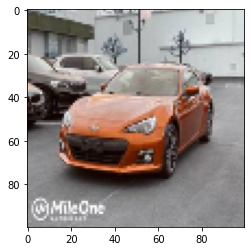

In [ ]:
#  image path
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/cup_20.jpg'

#  performing visual test (Coupe)
visual_test(path, model_75, model_100,
            model_3=model_75x, model_4=model_100x, num_models=4)

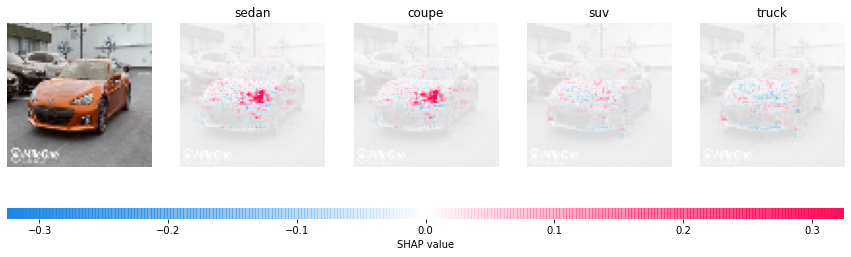

In [ ]:
#  model_75
plot_shap(path, mask_75, 75, model_75)

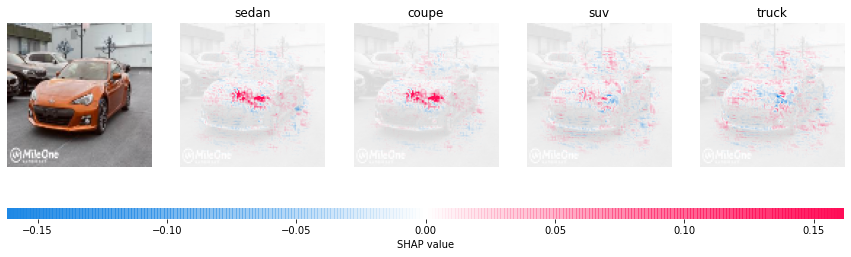

In [ ]:
#  model_100
plot_shap(path, mask_100, 100, model_100)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


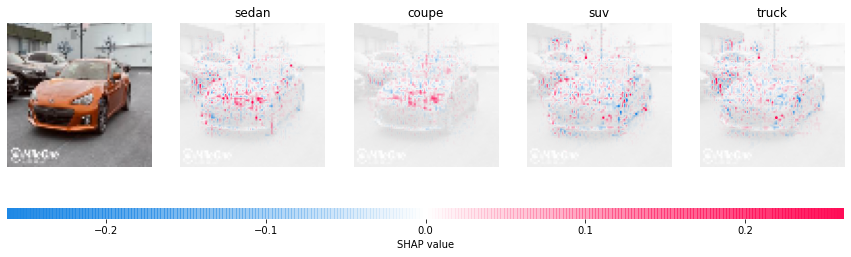

In [ ]:
#  model 75 (improved)
plot_shap(path, mask_75, 75, model_75x)

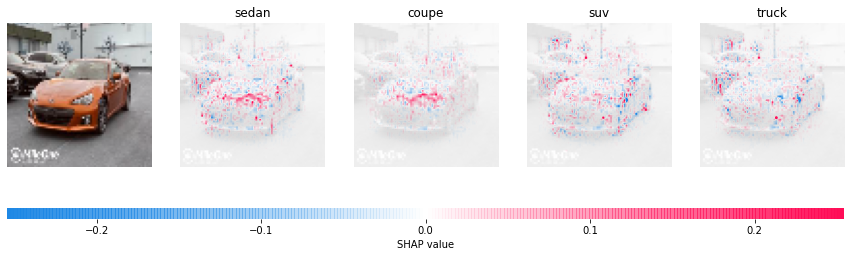

In [ ]:
#  model_100 (improved)
plot_shap(path, mask_100, 100, model_100x)

model 75x75px
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
prediction: suv
_______________________________________________________
model 75x75px (improved)
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
prediction: suv
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
prediction: suv
_______________________________________________________
model 100x100px (improved)
sedan: 18.0%, coupe: 18.0%, suv: 47.0%, truck: 18.0%
prediction: suv
_______________________________________________________
average class prediction
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
prediction: suv
_______________________________________________________
highest confidence
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
sedan: 17.0%, coupe: 17.0%, suv: 48.0%, truck: 17.0%
sedan: 18.0%, coupe: 17.0%, suv: 47.0%, truck: 17.0%
sedan: 18.0%, coupe: 18.0%, suv: 47.0%, truck: 18.0%
prediction: suv


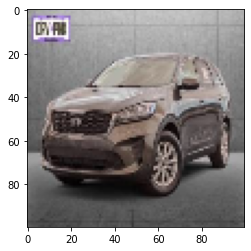

In [ ]:
#  performing visual test (SUV)
visual_test(path, model_75, model_100,
            model_3=model_75x, model_4=model_100x, num_models=4)

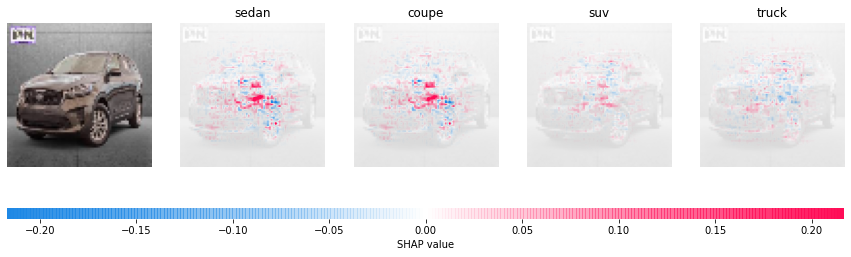

In [ ]:
#  model_75
plot_shap(path, mask_75, 75, model_75)

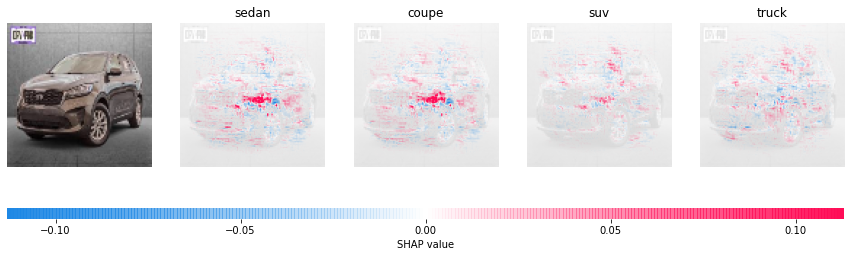

In [ ]:
#  model_100
plot_shap(path, mask_100, 100, model_100)

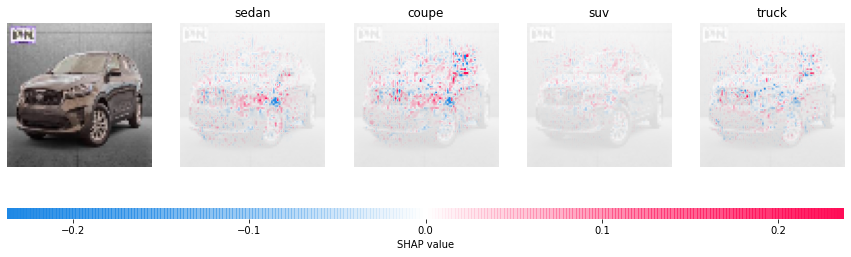

In [ ]:
#  model_75 (improved)
plot_shap(path, mask_75, 75, model_75x)

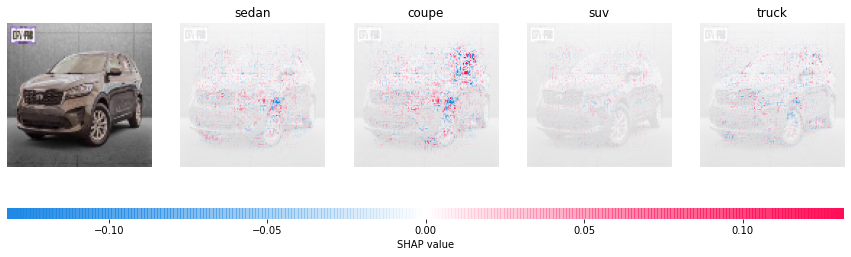

In [ ]:
#  model_100 (improved)
plot_shap(path, mask_100, 100, model_100x)

model 75x75px
sedan: 19.0%, coupe: 19.0%, suv: 34.0%, truck: 28.0%
prediction: suv
_______________________________________________________
model 75x75px (improved)
sedan: 17.0%, coupe: 17.0%, suv: 17.0%, truck: 48.0%
prediction: truck
_______________________________________________________
model 100x100px
sedan: 18.0%, coupe: 18.0%, suv: 19.0%, truck: 45.0%
prediction: truck
_______________________________________________________
model 100x100px (improved)
sedan: 17.0%, coupe: 17.0%, suv: 18.0%, truck: 47.0%
prediction: truck
_______________________________________________________
average class prediction
sedan: 18.0%, coupe: 18.0%, suv: 22.0%, truck: 42.0%
prediction: truck
_______________________________________________________
highest confidence
sedan: 19.0%, coupe: 19.0%, suv: 34.0%, truck: 28.0%
sedan: 17.0%, coupe: 17.0%, suv: 17.0%, truck: 48.0%
sedan: 18.0%, coupe: 18.0%, suv: 19.0%, truck: 45.0%
sedan: 17.0%, coupe: 17.0%, suv: 18.0%, truck: 47.0%
prediction: truck


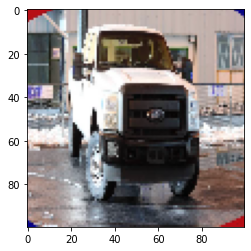

In [36]:
#  performing visual test (Truck)
visual_test(path, model_75, model_100,
            model_3=model_75x, model_4=model_100x, num_models=4)

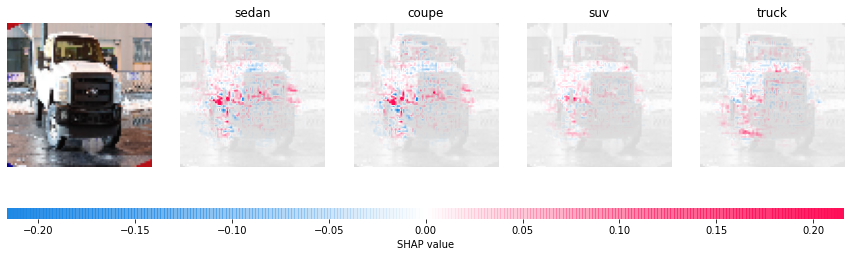

In [ ]:
#  model_75
plot_shap(path, mask_75, 75, model_75)

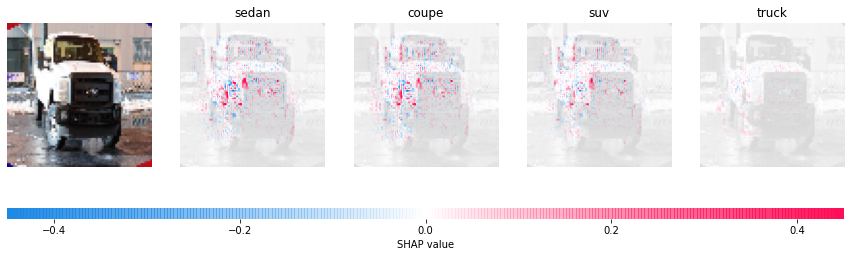

In [ ]:
#  model_75 (improved)
plot_shap(path, mask_75, 75, model_75x)

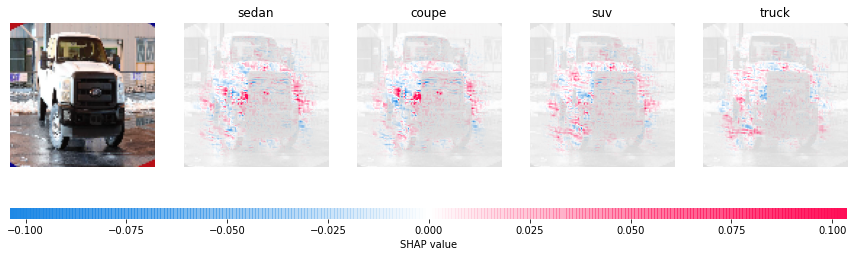

In [ ]:
#  model_100
plot_shap(path, mask_100, 100, model_100)

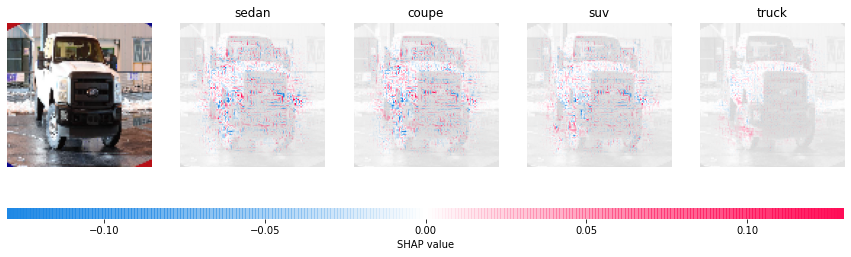

In [ ]:
#  model_100 (improved)
plot_shap(path, mask_100, 100, model_100x)

model 75x75px
sedan: 30.0%, coupe: 32.0%, suv: 19.0%, truck: 19.0%
prediction: coupe
_______________________________________________________
model 75x75px (improved)
sedan: 47.0%, coupe: 18.0%, suv: 18.0%, truck: 18.0%
prediction: sedan
_______________________________________________________
model 100x100px
sedan: 22.0%, coupe: 41.0%, suv: 19.0%, truck: 18.0%
prediction: coupe
_______________________________________________________
model 100x100px (improved)
sedan: 42.0%, coupe: 21.0%, suv: 18.0%, truck: 18.0%
prediction: sedan
_______________________________________________________
average class prediction
sedan: 35.0%, coupe: 28.0%, suv: 18.0%, truck: 18.0%
prediction: sedan
_______________________________________________________
highest confidence
sedan: 30.0%, coupe: 32.0%, suv: 19.0%, truck: 19.0%
sedan: 47.0%, coupe: 18.0%, suv: 18.0%, truck: 18.0%
sedan: 22.0%, coupe: 41.0%, suv: 19.0%, truck: 18.0%
sedan: 42.0%, coupe: 21.0%, suv: 18.0%, truck: 18.0%
prediction: sedan


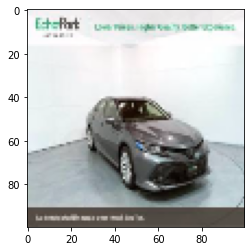

In [37]:
#  performing visual test (Sedan)
visual_test(path, model_75, model_100,
            model_3=model_75x, model_4=model_100x, num_models=4)

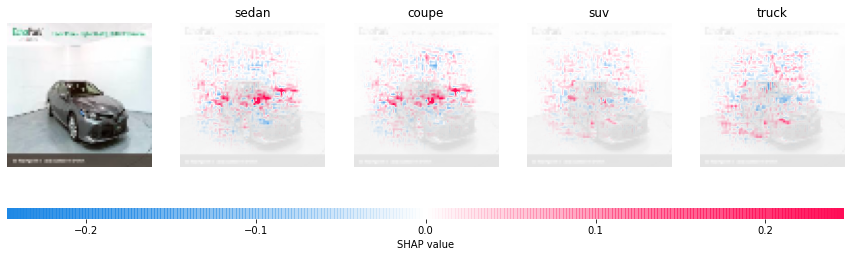

In [ ]:
#  model_75
plot_shap(path, mask_75, 75, model_75)

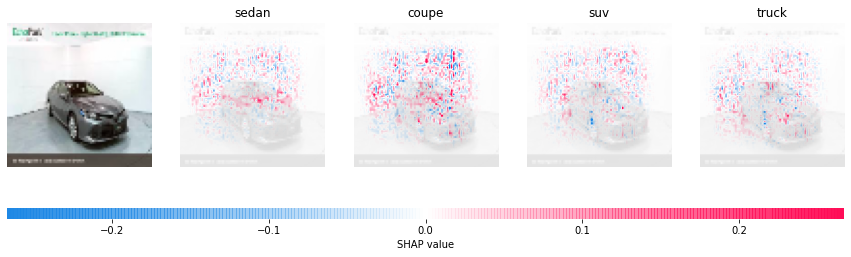

In [ ]:
#  model_75 (improved)
plot_shap(path, mask_75, 75, model_75x)

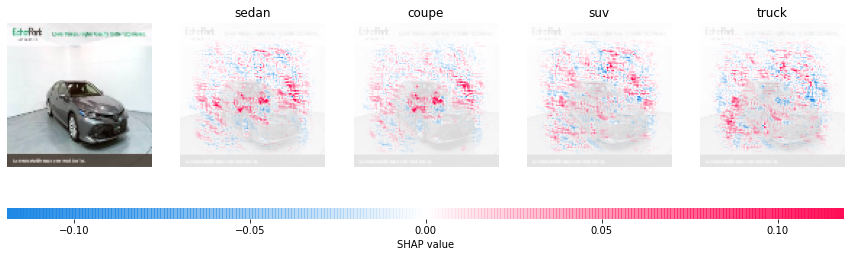

In [ ]:
#  model_100
plot_shap(path, mask_100, 100, model_100)

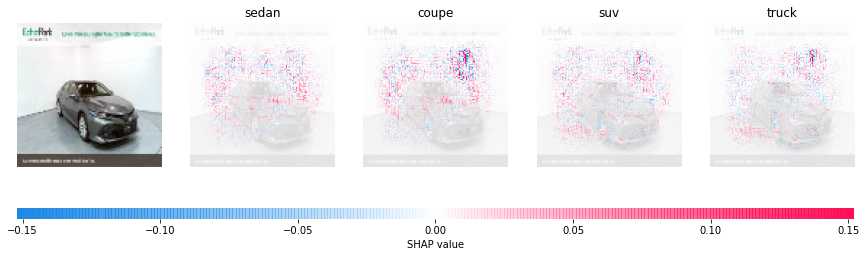

In [ ]:
#  model_100 (improved)
plot_shap(path, mask_100, 100, model_100x)

In general, looking at the shap plots, significant pixels for the baseline models are localised while those of the batch normalized models are more dispersed. This implies that the batch normalized models utilize more image features which explains their superior performance. 

Worthy of note is the fact that models pick up some background images as significant. This is expected as a segmentation model is not present to detect pixels pertaining only to cars.

### **4.6 Model Testing and Analysis**
As stated in 4.4.4 above, the fact that the test sets for the 75 and 100px images were different hindered proper comparision of models. In this section, new test sets are built, with both sets containing the same images.

In [84]:
#  loading test images
test_75 = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/Car75_test.npy', 
                  allow_pickle=True)

test_100 = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/Car100_test.npy', 
                  allow_pickle=True)

#  loading unshuffled test images
test_75_US = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/Car75_testUS.npy', 
                  allow_pickle=True)

test_100_US = np.load('gdrive/My Drive/Neural Networks/loaded_npy_files/Car100_testUS.npy', 
                  allow_pickle=True)

In [85]:
#  creating instances of the dataset class for test images
test_75_ds = VehicleDataset(test_75, transforms=transforms.ToTensor())
test_100_ds = VehicleDataset(test_100, transforms=transforms.ToTensor())
test_75_dsUS = VehicleDataset(test_75_US, transforms=transforms.ToTensor())
test_100_dsUS = VehicleDataset(test_100_US, transforms=transforms.ToTensor())

#  creating dataloaders
batch_size = 200
test_75_dl = DataLoader(test_75_ds, batch_size=batch_size)
test_100_dl = DataLoader(test_100_ds, batch_size=batch_size)
test_75_dlUS = DataLoader(test_75_dsUS, batch_size=batch_size)
test_100_dlUS = DataLoader(test_100_dsUS, batch_size=batch_size)

#### **4.6.1 Testing**

In [95]:
def compare_accuracies(*args, labels=[]):
  """
  This function compares the accuracies 
  of a number of models and returns a bar
  chart.
  """
  scores = []
  i=0

  for arg in args:
    print(f'\ncomputing for {labels[i]}...')
    score = accuracy(arg[0], arg[1])*100
    print(f'accuracy = {round(score,2)}%')
    scores.append(score)
    i+=1
  
  plt.figure(figsize=(8,5.5))
  sns.barplot(x=scores, y=labels)
  pass


computing for model_75...


  0%|          | 0/12 [00:00<?, ?it/s]

accuracy = 92.08%

computing for model_75(improved)...


  0%|          | 0/12 [00:00<?, ?it/s]

accuracy = 95.91%

computing for model_100...


  0%|          | 0/12 [00:00<?, ?it/s]

accuracy = 91.79%

computing for model_100(improved)...


  0%|          | 0/12 [00:00<?, ?it/s]

accuracy = 96.08%


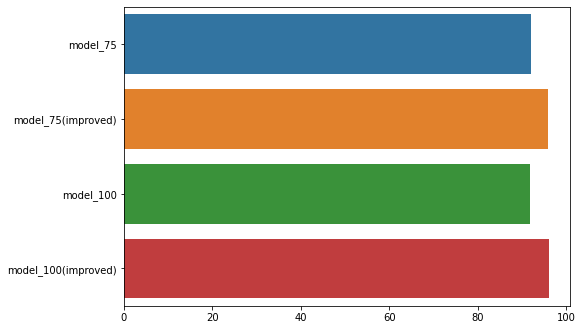

In [94]:
#  comparing all 4 models
compare_accuracies([model_75, test_75_dl],
                   [model_75x, test_75_dl],
                   [model_100, test_100_dl],
                   [model_100x, test_100_dl],
                   labels=['model_75', 'model_75(improved)',
                           'model_100', 'model_100(improved)'])

#### **4.6.2 Classification Analysis**

In [ ]:
def extract_results(network, dataloader, file_name):
  """
  This function performs model classifications and 
  returns both classifications and actual labels in 
  a dataframe.
  """
  #  creating an empty list
  results = []
  labels = []

  #  classification
  with torch.no_grad():
    for img, lb in tqdm(dataloader):
      img, lb = img.to(device), lb.to(device)
      preds = network(img)
      results.extend(torch.argmax(preds, dim=1).tolist())
      labels.extend(lb.tolist())

  df = pd.DataFrame({'predicted': results, 'labels': labels})
  df.to_csv(f'gdrive/My Drive/Neural Networks/Test_results/{file_name}', 
            index=False)
  print('\nDone!')
  return df.head()

In [98]:
#  defining mapping function
def convert_labels(instance):
  """
  This function converts
  numerical labels to strings
  """
  if instance == 0:
    instance = 'sedan'
  elif instance == 1:
    instance = 'coupe'
  elif instance == 2:
    instance = 'suv'
  elif instance == 3:
    instance = 'truck'
  return instance


#  defining function to map function
def map_df(df, map_func, columns=[]):
  """
  This function maps a function
  to specific columns
  """
  for i in range(len(columns)):
    df[columns[i]] = df[columns[i]].map(map_func)
  return df


#  defining function to filter misclassifications
def misclass_filter(df):
  """
  This function returns 
  instances where predicted 
  and actual labels are not
  the same
  """
  return df[df['predicted']!=df['labels']]


#  defining summary function
def misclass_summary(df1, df2, df3, df4):
  """
  This function returns a numerical count
  of missclassified instances
  """
  summary = pd.DataFrame({'model_75px': df1['labels'].value_counts().sort_index().values,
                          'model_75px(improved)':df2['labels'].value_counts().sort_index().values,
                          'model_100px':df3['labels'].value_counts().sort_index().values,
                          'model_100px(improved)':df4['labels'].value_counts().sort_index().values},
                         index=df1['labels'].value_counts().sort_index().index)
  return summary

In [ ]:
#  sample of test results extraction
extract_results(model_100, test_100_dl, 'CarType100_results.csv')

In [97]:
#  loading extracted test results
test_75_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType75_results.csv')
test_75x_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType75(improved)_results.csv')
test_100_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType100_results.csv')
test_100x_results = pd.read_csv('gdrive/My Drive/Neural Networks/Test_results/CarType100(improved)_results.csv')

In [ ]:
#  converting numerical labels into strings
test_75_results = map_df(test_75_results, 
                         convert_labels, 
                         columns=['predicted', 'labels'])

test_75x_results = map_df(test_75x_results, 
                          convert_labels, 
                          columns=['predicted', 'labels'])

test_100_results = map_df(test_100_results, 
                          convert_labels, 
                          columns=['predicted', 'labels'])

test_100x_results = map_df(test_100x_results, 
                           convert_labels, 
                           columns=['predicted', 'labels'])

In [ ]:
#  previewing converted labels
test_75x_results.head()

predicted labels
0       suv    suv
1     truck  truck
2     sedan  sedan
3       suv    suv
4     coupe  coupe

In [ ]:
#  filtering out misclassified instances
misclassified_75 = misclass_filter(test_75_results)
misclassified_75x = misclass_filter(test_75x_results)
misclassified_100 = misclass_filter(test_100_results)
misclassified_100x = misclass_filter(test_100x_results)

In [ ]:
#  summarizing misclassifications
misclassification_summary = misclass_summary(misclassified_75, misclassified_75x,
                                            misclassified_100, misclassified_100x)

misclassification_summary

model_75px  model_75px(improved)  model_100px  model_100px(improved)
coupe          32                    28           16                     12
sedan          61                    24           86                     35
suv            73                    25           57                     36
truck          22                    20           36                     10

In [ ]:
#  total misclassifications by model
misclassification_summary.sum()

model_75px               188
model_75px(improved)      97
model_100px              195
model_100px(improved)     93
dtype: int64

From accuracy comparison and the missclassification summary, it is again evident that the batch normalized models outperformed the baselines. it is also evident that the 100px(improved) model handles coupe and truck classification better while the 75px(improved) model is better at handling sedans and suvs.



---


### **4.7 Model Ensembling**
Because of the close performance of the improved 75px and 100px models, and also because both models have exibited unique strengths in handling different car classes, there is a strong case for model ensembling so as to create a model which draws upon the strength of both models.

#### **4.7.1 Priority Ensemble**
This is a custom ensemble where the two models work in tandem by ceding priority depending on the image instance. Since the 75px(improved) and 100px(improved) models perform differently on on car classes, priority is given to a model whenever it predicts its strong point (coupe/truck for the 100px model and sedan/suv for the 75px model). However, if neither model predicts its strong point, priority is returned to the most accurate model which is the 100px model.

#### **4.7.2 Average Ensemble**
Here model confidences on classifying a particular image are averaged before deriving the predicted class. This will allow for better classification of borderline instances where one model is less confidenct of the superior class

In [101]:
def ensemble(model_1, model_2, dl_1, dl_2, mode, accuracy=False):
  """
  This function tests the two proposed ensembling methods
  """
  if mode==1:
    #  setting model states
    model_1.eval()
    model_2.eval()
    #  creating counters for accuracy
    correct_instances = 0
    all_instances = 0
    actual_labels = []
    model_1_preds = []
    model_2_preds = []
    ensemble_preds = []

    with torch.no_grad():
      print('model_1...')
      for img_1, lb_1 in tqdm(dl_1):
        output_1 = model_1(img_1)
        output_1 = torch.argmax(output_1, dim=1)
        model_1_preds.extend(output_1)
        actual_labels.extend(lb_1)

      print('\nmodel_2...')
      for img_2, lb_2 in tqdm(dl_2):
        output_2 = model_2(img_2)
        output_2 = torch.argmax(output_2, dim=1)
        model_2_preds.extend(output_2)

      model_1_preds = torch.tensor(model_1_preds)
      model_2_preds = torch.tensor(model_2_preds)
      actual_labels = torch.tensor(actual_labels)
      output_3 = torch.ones_like(model_1_preds)

      print('\nensembling...')
      for i in tqdm(range(len(model_1_preds))):
        if model_1_preds[i].item() in [0, 2] and model_2_preds[i].item not in [1, 3]:
          output_3[i] = model_1_preds[i]
        else:
          output_3[i] = model_2_preds[i]
#  by this logic, the most accurate model (100px) is given priority if either 
#  model fails to predict its strong point(sedan and suv for 75px, coupe and 
#  truck for 100px)
      print('\ncomputing accuracy...')
      correct = sum(output_3==actual_labels)
      correct_instances+=correct.item()
      all_instances+=len(actual_labels)

      acc = (correct_instances/all_instances)*100
      print(f'[{correct_instances}/{all_instances}]\n{round(acc, 2)}%')
    print('Done!')

  if mode==2:
    #  setting model states
    model_1.eval()
    model_2.eval()
    #  creating counters for accuracy
    correct_instances = 0
    all_instances = 0
    actual_labels = []
    model_1_preds = []
    model_2_preds = []
    ensemble_preds = []

    with torch.no_grad():
      print('model_1...')
      for img_1, lb_1 in tqdm(dl_1):
        output_1 = model_1(img_1)
        model_1_preds.append(output_1)
        actual_labels.append(lb_1)

      print('\nmodel_2...')
      for img_2, lb_2 in tqdm(dl_2):
        output_2 = model_2(img_2)
        model_2_preds.append(output_2)

      print('\nensembling...')
      for i in tqdm(range(len(model_1_preds))):
        output_3 = torch.ones((2,model_1_preds[i].shape[0], 
                              model_1_preds[i].shape[1]))
        output_3[0] = model_1_preds[i]
        output_3[1] = model_2_preds[i]
        output_3 = output_3.mean(dim=0)
        output_3 = torch.argmax(output_3, dim=1)

        correct = sum(output_3==actual_labels[i])
        correct_instances+=correct.item()
        all_instances+=len(actual_labels[i])
    
    acc = correct_instances/all_instances*100
    print(f'\n\n[{correct_instances}/{all_instances}]\n{round(acc,2)}%')
    print('Done!')

In [102]:
#  testing priority
ensemble(model_75x, model_100x,
         test_75_dlUS, test_100_dlUS, 1)

model_1...


100%|██████████| 12/12 [00:23<00:00,  1.95s/it]



model_2...


100%|██████████| 12/12 [00:42<00:00,  3.54s/it]



ensembling...


100%|██████████| 2374/2374 [00:00<00:00, 106263.10it/s]


computing accuracy...
[2283/2374]
96.17%
Done!


In [103]:
#  testing average
ensemble(model_75x, model_100x,
         test_75_dlUS, test_100_dlUS, 2)

model_1...


100%|██████████| 12/12 [00:21<00:00,  1.82s/it]



model_2...


100%|██████████| 12/12 [00:41<00:00,  3.44s/it]



ensembling...


100%|██████████| 12/12 [00:00<00:00, 669.99it/s]



[2307/2374]
97.18%
Done!


Text(0.5, 0, 'accuracy (%)')

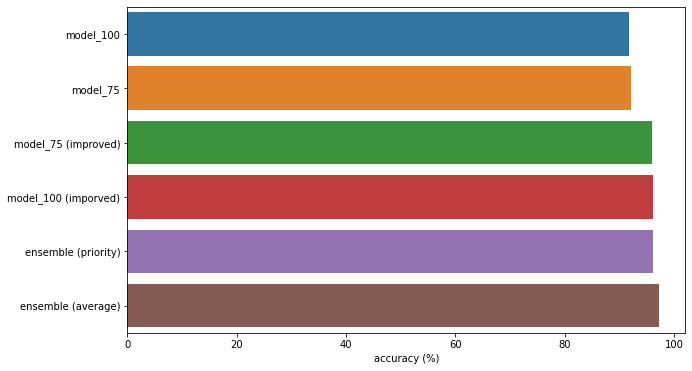

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(y=['model_100', 'model_75', 'model_75 (improved)', 
               'model_100 (imporved)', 'ensemble (priority)', 'ensemble (average)'],
            x=[91.79, 92.08, 95.91, 96.08, 96.17, 97.18])
plt.xlabel('accuracy (%)')

An improvment in performance is observed for both ensemble modes, they will both be selected for deployment with the average ensemble method selected as default.


---

### **4.8 Model Ensembling Class**

In [ ]:
#  defining ensemble class
class EnsembleModels():
  def __init__(self, model_1, model_2):
    self.model_1 = model_1
    self.model_2 = model_2

  def priority(self, image_path):
    with torch.no_grad():
      #  setting model states
      self.model_1.eval()
      self.model_2.eval()
      
      #  reading image from path
      image = cv2.imread(image_path)
      #  resizing image
      image_75 = cv2.resize(image, (75,75))
      image_100 = cv2.resize(image, (100,100))
      #  converting images to tensor
      image_75 = transforms.ToTensor()(image_75)
      image_100 = transforms.ToTensor()(image_100)

      #  making predictions
      output_1 = self.model_1(image_75)
      output_2 = self.model_2(image_100)

      #  deriving probabilities
      output_1p = F.softmax(F.softmax(output_1, dim=1), dim=1)*100
      output_2p = F.softmax(F.softmax(output_2, dim=1), dim=1)*100

      #  determining predicted class
      output_1x = torch.argmax(output_1, dim=1)
      output_2x = torch.argmax(output_2, dim=1)

      #  class dictionary
      class_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}

      #  priority logic
      if output_1x.item() in [0,2] and output_2x.item() not in [1,3]:
        output_3 = output_1x.item()
        return str('model_75x'+
              f' | sedan: {output_1p[0][0].round()}% coupe: {output_1p[0][1].round()}%'+ 
              f' suv: {output_1p[0][2].round()}% truck: {output_1p[0][3].round()}%'+
              f' | prediction: {class_dict[output_3]}')
      else:
        output_3 = output_2x.item()
        return str('model_100x'+
              f' | sedan: {output_2p[0][0].round()}% coupe: {output_2p[0][1].round()}%'+ 
              f' suv: {output_2p[0][2].round()}% truck: {output_2p[0][3].round()}%'+
              f' | prediction: {class_dict[output_3]}')

  def average_confidence(self, image_path):
    with torch.no_grad():
      #  setting model states
      self.model_1.eval()
      self.model_2.eval()
      
      #  reading image from path
      image = cv2.imread(image_path)
      #  resizing image
      image_75 = cv2.resize(image, (75,75))
      image_100 = cv2.resize(image, (100,100))
      #  converting images to tensor
      image_75 = transforms.ToTensor()(image_75)
      image_100 = transforms.ToTensor()(image_100)

      #  making predictions
      output_1 = self.model_1(image_75)
      output_2 = self.model_2(image_100)

      #  creating placeholder tensor
      placeholder = torch.ones((2,4))
      #  inputing tensors
      placeholder[0] = output_1
      placeholder[1] = output_2 

      #  computing average
      output_3 = placeholder.mean(dim=0)

      #  deriving probabilities
      output_3p = F.softmax(F.softmax(output_3, dim=0), dim=0)*100

      #  deriving predicted class
      idx_p = torch.argmax(output_3, dim=0)

      #  class dictionary
      class_dict = {0:'sedan', 1:'coupe', 2:'suv', 3:'truck'}

      #  printing to screen
      return str(f'sedan: {output_3p[0].round()}% coupe: {output_3p[1].round()}%'+ 
                  f' suv: {output_3p[2].round()}% truck: {output_3p[3].round()}%'+
                  f' | prediction: {class_dict[idx_p.item()]}')

In [ ]:
path = 'gdrive/My Drive/Datasets/Car_Images/visual_test_images/trk_28.jpg'

#  instantiating ensemble
model_ex = EnsembleModels(model_75x, model_100x)

#  using the average method
model_ex.average_confidence(path)

'sedan: 17.0% coupe: 17.0% suv: 17.0% truck: 48.0% | prediction: truck'

In [ ]:
#  using the priority method
model_ex.priority(path)

'model_100x | sedan: 17.0% coupe: 17.0% suv: 17.0% truck: 48.0% | prediction: truck'

### **4.9 Flask Deployment**

In [ ]:
!pip install flask-ngrok

In [ ]:
#  CHECK_
!pip install pyngrok==4.1.1
!ngrok authtoken 23xeK0d2nO40rNkOzrkUp3YMNnM_WjJQnNbGiT9jvNvaxi2v

In [ ]:
#  creating templates directory and copying template
os.mkdir('templates')
shutil.copy2('gdrive/My Drive/templates/predict.html', 'templates')

'templates/predict.html'

In [ ]:
from flask import Flask, request, render_template, url_for
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)

@app.route('/')
def home():
    return render_template('predict.html')

@app.route('/predict', methods=['POST', 'GET'])
def predict():
  if request.method=='POST':
    image = request.files['image']
    image.save('to_pred.jpg', int(2e+6))
    return model_ex.average_confidence('to_pred.jpg')
  else:
    return home()


app.run()